In [1]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [2]:
import numpy as np
import os

# Directory containing CIFAR-10 batches
data_dir = 'D:\\CSE 440\\cifar-10-batches-py'

# Load all data batches
def load_cifar10_data(data_dir):
    # Initialize empty lists for images and labels
    images = []
    labels = []
    
    # Load each data batch
    for batch_id in range(1, 6):
        batch = unpickle(os.path.join(data_dir, f'data_batch_{batch_id}'))
        images.append(batch[b'data'])
        labels += batch[b'labels']
    
    # Stack the image arrays and reshape to (50000, 32, 32, 3)
    images = np.vstack(images).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels = np.array(labels)
    
    # Load the test batch
    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    test_images = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])
    
    return images, labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_cifar10_data(data_dir)
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import matplotlib.pyplot as plt
import os
import pickle

class CIFAR10CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_images_split, val_images, train_labels_split, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

train_dataset = CIFAR10CustomDataset(train_images_split, train_labels_split, transform=transform)
val_dataset = CIFAR10CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CIFAR10CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super(NeuralNet, self).__init__()
        self.model = timm.create_model('cait_s24_224.fb_dist_in1k', pretrained=True, num_classes=num_classes)    
        
        for parameter in self.model.parameters():
            parameter.requires_grad = False
    
        for parameter in self.model.head.parameters():
            parameter.requires_grad = True
        
    def forward(self, x):
        return self.model(x)

class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = [NeuralNet().to(device) for _ in range(population_size)]
    
    def train_model(self, model, train_loader, criterion, optimizer, scheduler, epochs):
        model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            correct = 0
            total = 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
    
                # Zero the parameter gradients
                optimizer.zero_grad()
    
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
    
                # Accumulate loss
                running_loss += loss.item()
    
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
            train_acc = 100 * correct / total
    
            # Calculate average loss for the epoch
            avg_loss = running_loss / len(train_loader)
            
            # Scheduler step with the validation metric
            scheduler.step(avg_loss)  # Use the average training loss as the metric
    
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        return train_acc


    def evaluate_model(self, model, val_loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).long()
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        return val_acc

    def mutate(self, model):
        # Mutate the model weights with some noise
        with torch.no_grad():
            for param in model.parameters():
                if torch.rand(1).item() < self.mutation_rate:
                    noise = torch.randn_like(param) * 0.05  # Adjust noise scale as needed
                    param.add_(noise)

    def run_evolution(self):
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        best_model = None

        for generation in range(self.generations):
            print(f"Generation {generation + 1}/{self.generations}")

            accuracies = []
            for idx, model in enumerate(self.population):
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
                
                train_acc = self.train_model(model, train_loader, criterion, optimizer, scheduler, epochs=5)
                val_acc = self.evaluate_model(model, val_loader)
                accuracies.append(val_acc)
                print(f"Model {idx + 1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

                # Check if this is the best model so far
                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    best_model = model

            # Reproduction: Select two best models to reproduce
            sorted_indices = np.argsort(accuracies)[-2:]
            parent1, parent2 = self.population[sorted_indices[0]], self.population[sorted_indices[1]]

            # Generate new population through crossover and mutation
            new_population = []
            for _ in range(self.population_size):
                child = NeuralNet().to(device)
                child.load_state_dict(parent1.state_dict(), strict=False)
                self.mutate(child)
                new_population.append(child)

            self.population = new_population

        # Evaluate the best model on the test set
        test_accuracy = self.evaluate_model(best_model, test_loader)
        print(f"Test Accuracy of the best model: {test_accuracy:.2f}%")
        
        # Return the best model for later use
        return best_model

# Run Genetic Algorithm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GA = GeneticAlgorithm(population_size=8, mutation_rate=0.05, generations=4)
best_model = GA.run_evolution()

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generation 1/4


C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/5], Loss: 0.2234, Train Acc: 93.28%
Epoch [2/5], Loss: 0.1498, Train Acc: 95.00%
Epoch [3/5], Loss: 0.1390, Train Acc: 95.34%
Epoch [4/5], Loss: 0.1305, Train Acc: 95.71%
Epoch [5/5], Loss: 0.1169, Train Acc: 96.13%
Model 1: Train Acc = 96.13%, Val Acc = 95.08%
Epoch [1/5], Loss: 0.2282, Train Acc: 93.19%
Epoch [2/5], Loss: 0.1507, Train Acc: 95.05%
Epoch [3/5], Loss: 0.1375, Train Acc: 95.45%
Epoch [4/5], Loss: 0.1311, Train Acc: 95.72%
Epoch [5/5], Loss: 0.1166, Train Acc: 96.10%
Model 2: Train Acc = 96.10%, Val Acc = 95.00%
Epoch [1/5], Loss: 0.2238, Train Acc: 93.27%
Epoch [2/5], Loss: 0.1507, Train Acc: 94.97%
Epoch [3/5], Loss: 0.1383, Train Acc: 95.41%
Epoch [4/5], Loss: 0.1311, Train Acc: 95.58%
Epoch [5/5], Loss: 0.1173, Train Acc: 96.15%
Model 3: Train Acc = 96.15%, Val Acc = 95.00%
Epoch [1/5], Loss: 0.2220, Train Acc: 93.36%
Epoch [2/5], Loss: 0.1507, Train Acc: 95.00%
Epoch [3/5], Loss: 0.1379, Train Acc: 95.50%
Epoch [4/5], Loss: 0.1311, Train Acc: 95.70%
Epoch [

<h1>GA with Adam</h1>

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
criterion = nn.CrossEntropyLoss()

def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

# Testing the model
test_loss, true_labels, predictions = test_model(best_model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Classification Report
print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.1537
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9413    0.9620    0.9515      1000
  automobile     0.9672    0.9720    0.9696      1000
        bird     0.9419    0.9410    0.9415      1000
         cat     0.9034    0.8980    0.9007      1000
        deer     0.9490    0.9300    0.9394      1000
         dog     0.9154    0.9310    0.9232      1000
        frog     0.9726    0.9580    0.9652      1000
       horse     0.9608    0.9550    0.9579      1000
        ship     0.9701    0.9750    0.9726      1000
       truck     0.9620    0.9610    0.9615      1000

    accuracy                         0.9483     10000
   macro avg     0.9484    0.9483    0.9483     10000
weighted avg     0.9484    0.9483    0.9483     10000

Confusion Matrix:
[[962   1   8   5   0   0   1   1  15   7]
 [  5 972   0   1   0   0   0   0   0  22]
 [ 13   0 941  11  15   5   9   3   3   0]
 [  4   2  10 898  10  55   8   5   3   5]
 [  2   1 

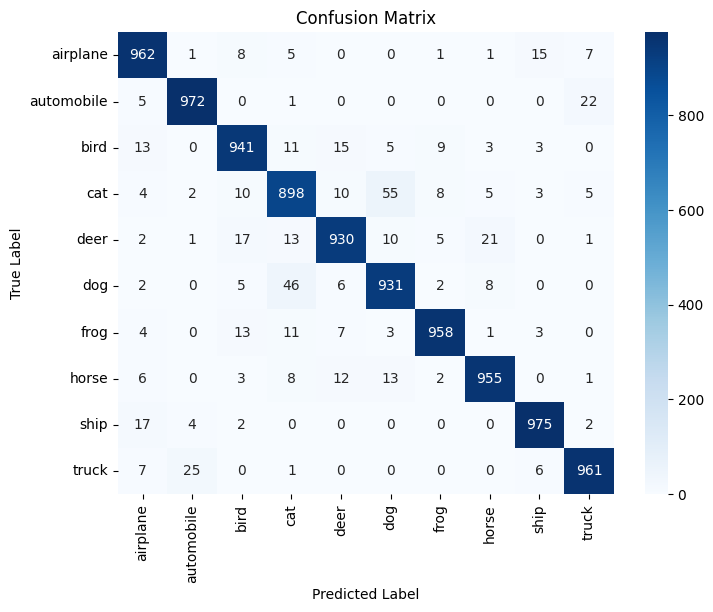

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

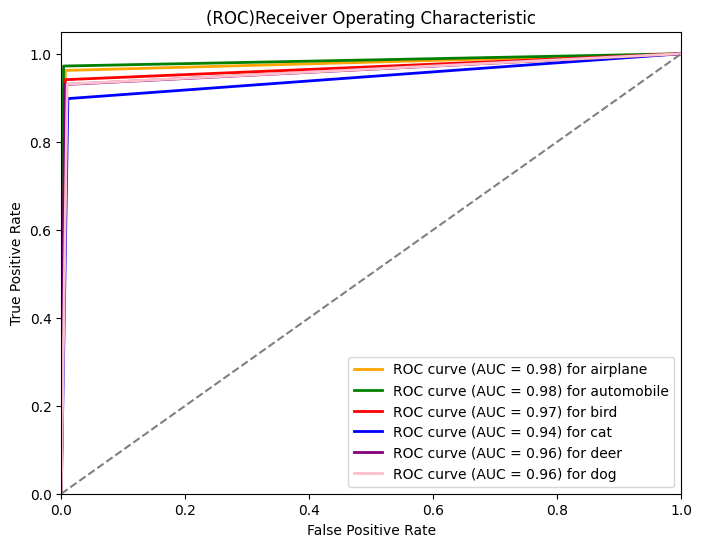

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

<h1>Training without GA</h1> 

In [14]:
import torch.nn as nn
import torch.optim as optim
import timm

num_classes = 10  

model = timm.create_model('cait_s24_224.fb_dist_in1k', pretrained=True, num_classes=num_classes)    
        
for parameter in model.parameters():
    parameter.requires_grad = False
    
for parameter in model.head.parameters():
    parameter.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.01)

In [17]:
from torchinfo import summary
summary(model = model, 
        input_size=(10, 3, 224, 224),  
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
Cait (Cait)                              [10, 3, 224, 224] [10, 10]        75,648          Partial
├─PatchEmbed (patch_embed)               [10, 3, 224, 224] [10, 196, 384]  --              False
│    └─Conv2d (proj)                     [10, 3, 224, 224] [10, 384, 14, 14] (295,296)       False
│    └─Identity (norm)                   [10, 196, 384]  [10, 196, 384]  --              --
├─Dropout (pos_drop)                     [10, 196, 384]  [10, 196, 384]  --              --
├─Sequential (blocks)                    [10, 196, 384]  [10, 196, 384]  --              False
│    └─LayerScaleBlock (0)               [10, 196, 384]  [10, 196, 384]  768             False
│    │    └─LayerNorm (norm1)            [10, 196, 384]  [10, 196, 384]  (768)           False
│    │    └─TalkingHeadAttn (attn)       [10, 196, 384]  [10, 196, 384]  (591,504)       False
│    │    └─Identity (drop_path)         [

In [20]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_accuracy, model):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accuracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accuracy, model):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_accuracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_accuracy

In [21]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model_with_early_stopping(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar2.pt')
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True, factor=0.1)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device).long()
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device).long()
                outputs = model(data)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / len(val_loader.dataset)

        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        scheduler.step(val_loss)

        early_stopping(val_accuracy, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Checkpoint\\model_checkpoint_cifar2.pt'))

    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=100,
    device=device,
    patience=10  
)

C:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Accuracy: 0.9213, Train Loss: 0.3814, Validation Loss: 0.3828, Validation Accuracy: 0.9285
Validation accuracy increased (inf --> 0.928500).  Saving model ...
Epoch 2/100, Train Accuracy: 0.9343, Train Loss: 0.3763, Validation Loss: 0.3888, Validation Accuracy: 0.9314
Validation accuracy increased (0.928500 --> 0.931400).  Saving model ...
Epoch 3/100, Train Accuracy: 0.9391, Train Loss: 0.3715, Validation Loss: 0.4788, Validation Accuracy: 0.9303
EarlyStopping counter: 1 out of 10
Epoch 4/100, Train Accuracy: 0.9407, Train Loss: 0.3751, Validation Loss: 0.4930, Validation Accuracy: 0.9344
Validation accuracy increased (0.931400 --> 0.934400).  Saving model ...
Epoch 5/100, Train Accuracy: 0.9437, Train Loss: 0.3696, Validation Loss: 0.4858, Validation Accuracy: 0.9350
Validation accuracy increased (0.934400 --> 0.935000).  Saving model ...
Epoch 6/100, Train Accuracy: 0.9440, Train Loss: 0.3746, Validation Loss: 0.5135, Validation Accuracy: 0.9326
EarlyStopping coun

C:\Users\User\AppData\Local\Temp\ipykernel_12072\3454503162.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\CSE 440\\Models\\Check

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def test_model(model, dataloader):
    model.eval()
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    
    return test_loss, true_labels, predictions

test_loss, true_labels, predictions = test_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')

print('Classification Report:')
print(classification_report(true_labels, predictions, digits=4, target_names=class_names))

cm = confusion_matrix(true_labels, predictions)
print('Confusion Matrix:')
print(cm)

Test Loss: 0.4249
Classification Report:
              precision    recall  f1-score   support

    airplane     0.9459    0.9450    0.9455      1000
  automobile     0.9671    0.9710    0.9691      1000
        bird     0.9365    0.9290    0.9327      1000
         cat     0.8843    0.8790    0.8816      1000
        deer     0.9345    0.9280    0.9313      1000
         dog     0.9062    0.8990    0.9026      1000
        frog     0.9526    0.9650    0.9588      1000
       horse     0.9557    0.9490    0.9523      1000
        ship     0.9631    0.9670    0.9651      1000
       truck     0.9518    0.9670    0.9593      1000

    accuracy                         0.9399     10000
   macro avg     0.9398    0.9399    0.9398     10000
weighted avg     0.9398    0.9399    0.9398     10000

Confusion Matrix:
[[945   2  11   3   1   0   2   4  22  10]
 [  3 971   1   0   0   0   0   0   1  24]
 [  9   0 929  16  21   3  12   4   4   2]
 [  6   1   5 879  12  62  17   8   1   9]
 [  3   1 

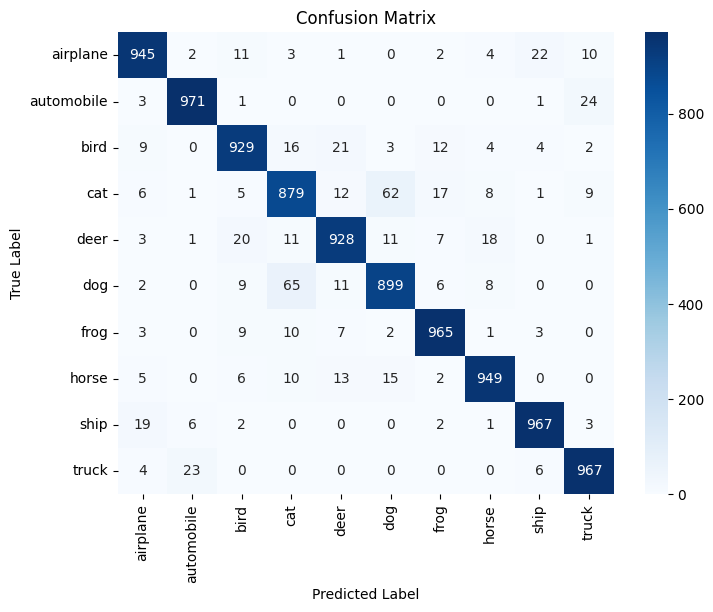

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

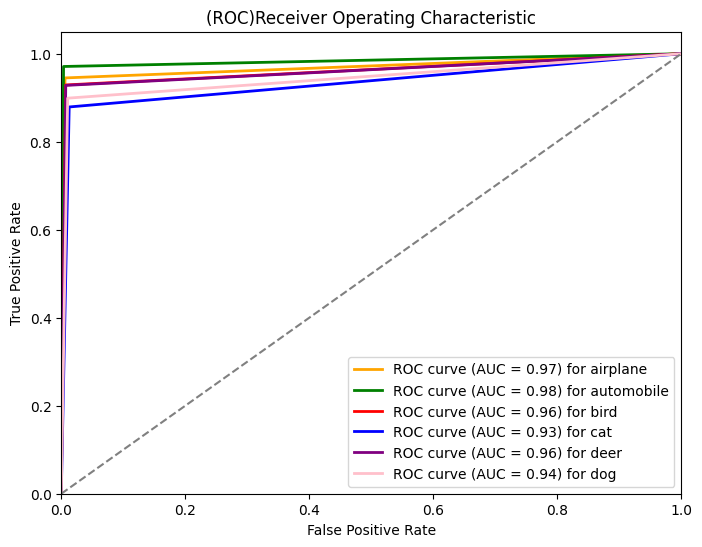

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()